<a href="https://colab.research.google.com/github/TomaszK98/convolutional_neural_networks/blob/main/Convolutional_neural_networks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import nibabel as nib
from scipy import ndimage
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Download url of normal and abnormal CT scans.
urls = [
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-normal-0.zip",
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-normal-1.zip",
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-abnormal-0.zip",
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-abnormal-1.zip",
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-normal-test.zip",
    "https://github.com/TomaszK98/convolutional_neural_networks/releases/download/v1.0.0/CT-abnormal-test.zip",
]
file_names = [
    "CT-normal-0.zip",
    "CT-normal-1.zip",
    "CT-abnormal-0.zip",
    "CT-abnormal-1.zip",
    "CT-normal-test.zip",
    "CT-abnormal-test.zip",
]

for url, file_name in zip(urls, file_names):
    filename = os.path.join(os.getcwd(), file_name)
    keras.utils.get_file(filename, url)
# Make a directory to store the data.
os.makedirs("CovidCTScans")

# Unzip data in the newly created directory.
for file_name in file_names:
    with zipfile.ZipFile(file_name, "r") as z_fp:
        z_fp.extractall("./CovidCTScans/")


536929326/536929326 [==============================] - 7s 0us/step


In [ ]:
class ProcessScanHandler:
    """Class responsible for processing CT scans - read images from nifti extension, normalize and resize image"""
    min_volume = -1000
    max_volume = 400
    desired_depth = 64
    desired_height = 128
    desired_width = 128

    def __init__(self, scans):
        self.scans = scans

    def run(self):
        return np.array([self.process_scan(path) for path in self.scans])

    def read_nifti_file(self, filepath):
        scan = nib.load(filepath)
        return scan.get_fdata()

    def normalize(self, volume):
        volume[volume < self.min_volume] = self.min_volume
        volume[volume > self.max_volume] = self.max_volume
        volume = (volume - self.min_volume) / (self.max_volume - self.min_volume)
        return volume.astype("float32")

    def resize_volume(self, img):
        # Get image current size
        image_depth = img.shape[-1]
        image_width = img.shape[0]
        image_height = img.shape[1]
        # Calculate depth ratio
        depth = image_depth / self.desired_depth
        width = image_width / self.desired_width
        height = image_height / self.desired_height
        depth_ratio = 1 / depth
        width_ratio = 1 / width
        height_ratio = 1 / height
        # Rotate the image
        img = ndimage.rotate(img, 90, reshape=False)
        # Resize the image across z-axis
        return ndimage.zoom(img, (width_ratio, height_ratio, depth_ratio), order=1)

    def process_scan(self, path):
        volume = self.read_nifti_file(path)
        volume = self.normalize(volume)
        return self.resize_volume(volume)

In [ ]:
# Load scan paths from CovidCTScans folder containing all downloaded CT images.
normal_scan_paths_1 = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-normal-0", x)
    for x in os.listdir("CovidCTScans/CT-normal-0")
]
normal_scan_paths_2 = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-normal-1", x)
    for x in os.listdir("CovidCTScans/CT-normal-1")
]
normal_scan_paths = normal_scan_paths_1 + normal_scan_paths_2

abnormal_scan_paths_1 = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-abnormal-0", x)
    for x in os.listdir("CovidCTScans/CT-abnormal-0")
]
abnormal_scan_paths_2 = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-abnormal-1", x)
    for x in os.listdir("CovidCTScans/CT-abnormal-1")
]
abnormal_scan_paths = abnormal_scan_paths_1 + abnormal_scan_paths_2


In [ ]:
# Process prepared scans using custom ProcessScanHandler(list_of_paths)
# Run processing using handler.run() and save it to variables
abnormal_scans_handler = ProcessScanHandler(abnormal_scan_paths)
normal_scans_handler = ProcessScanHandler(normal_scan_paths)
abnormal_scans = abnormal_scans_handler.run()
normal_scans = normal_scans_handler.run()

# Prepare arrays of labels - assing 1 for abnormal scans and 0 for normal scans
abnormal_labels = np.array([1 for _ in range(len(abnormal_scans))])
normal_labels = np.array([0 for _ in range(len(normal_scans))])

# Split whole dataset to train and validation dataset appropriately 280 and 120 scans
x_train = np.concatenate((abnormal_scans[:140], normal_scans[:140]), axis=0)
y_train = np.concatenate((abnormal_labels[:140], normal_labels[:140]), axis=0)
x_val = np.concatenate((abnormal_scans[140:], normal_scans[140:]), axis=0)
y_val = np.concatenate((abnormal_labels[140:], normal_labels[140:]), axis=0)


In [ ]:
# Prepare additional test dataset - process it and assign labels (keep whole dataset away during model training!)
normal_test_scan_paths = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-normal-test", x)
    for x in os.listdir("CovidCTScans/CT-normal-test")
]
abnormal_test_scan_paths = [
    os.path.join(os.getcwd(), "CovidCTScans/CT-abnormal-test", x)
    for x in os.listdir("CovidCTScans/CT-abnormal-test")
]

abnormal_test_scans_handler = ProcessScanHandler(abnormal_test_scan_paths)
normal_test_scans_handler = ProcessScanHandler(normal_test_scan_paths)
abnormal_test_scans = abnormal_test_scans_handler.run()
normal_test_scans = normal_test_scans_handler.run()

abnormal_test_labels = np.array([1 for _ in range(len(abnormal_test_scans))])
normal_test_labels = np.array([0 for _ in range(len(normal_test_scans))])

x_test = np.concatenate((abnormal_test_scans, normal_test_scans), axis=0)
y_test = np.concatenate((abnormal_test_labels, normal_test_labels), axis=0)

In [ ]:
@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def rotate_at_random_angles(volume):
        # define some rotation angles
        list_of_angles = [-20, -10, -5, 5, 10, 20]
        # pick angles at random
        random_angle = random.choice(list_of_angles)
        # rotate volume
        volume = ndimage.rotate(volume, random_angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(rotate_at_random_angles, [volume], tf.float32)
    return augmented_volume


def train_dataset_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume
    volume = rotate(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_and_test_dataset_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


In [ ]:
# Prepare data loaders using tensorflow dataset.
train_dataset_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_dataset_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 2
# Prepare finished datasets, ready to use in model training.
train_dataset = (
    train_dataset_loader.shuffle(len(x_train))
    .map(train_dataset_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

validation_dataset = (
    validation_dataset_loader.shuffle(len(x_val))
    .map(validation_and_test_dataset_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

In [ ]:
# Do the same for test dataset.
batch_size = 2
test_dataset_loader = tf.data.Dataset.from_tensor_slices((x_test, y_test))

# Prepare finished test dataset - ready to use in evaluate method.
test_dataset = test_dataset_loader.map(validation_and_test_dataset_preprocessing).batch(batch_size).prefetch(2)

In [ ]:
def get_cnn_model(
    width: int = 128,
    height: int = 128,
    depth: int = 64,
    filters: int = 32,
    filters_step: int = 2,
    kernel_size: int = 3,
    kernel_size_step: int = 0,
    conv_activation: str = "relu",
    dense_units: int = 4096,
    dropout: float = 0.3,
    pool_size: int = 2,
):

    inputs = keras.Input((width, height, depth, 1))

    x = layers.Conv3D(
        filters=filters, kernel_size=5, activation=conv_activation
    )(inputs)
    x = layers.MaxPool3D(pool_size=pool_size)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    

    x = layers.Conv3D(
        filters=filters * filters_step,
        kernel_size=kernel_size - kernel_size_step,
        activation=conv_activation,
    )(x)
    x = layers.MaxPool3D(pool_size=pool_size)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)
    

    x = layers.Conv3D(
        filters=filters * (filters_step * 2),
        kernel_size=kernel_size - kernel_size_step * 2,
        activation=conv_activation,
    )(x)
    x = layers.Conv3D(
        filters=filters * (filters_step * 3),
        kernel_size=kernel_size - kernel_size_step * 2,
        activation=conv_activation,
    )(x)
    x = layers.MaxPool3D(pool_size=pool_size)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    x = layers.Conv3D(
        filters=filters * (filters_step * 4),
        kernel_size=kernel_size - kernel_size_step * 3,
        activation=conv_activation,
    )(x)
    x = layers.Conv3D(
        filters=filters * (filters_step * 5),
        kernel_size=kernel_size - kernel_size_step * 3,
        activation=conv_activation,
    )(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(dropout)(x)

    
    x = layers.GlobalAveragePooling3D()(x)
    x = layers.Dense(units=dense_units, activation=conv_activation)(x)
    x = layers.Dropout(dropout)(x)

    outputs = layers.Dense(units=1, activation="sigmoid")(x)

    return keras.Model(inputs, outputs, name="3dcnn_final")


# Build model.

model = get_cnn_model()
model.summary()


Model: "3dcnn_final"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 64, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 124, 124, 60, 32)  4032      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 62, 62, 30, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 62, 62, 30, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 62, 62, 30, 32)    0         
                                                       

In [ ]:
initial_learning_rate = 0.0001
learning_rate = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
metrics = [
    tf.keras.metrics.BinaryAccuracy(name="accuracy"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
]
model.compile(
    loss="binary_crossentropy",
    optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    metrics=metrics,
)

# Define callbacks.
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    "3d_image_classification.h5", save_best_only=True
)
model_early_stopping_callback = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,
    callbacks=[model_checkpoint_callback, model_early_stopping_callback],
)


Epoch 1/100


KeyboardInterrupt: ignored

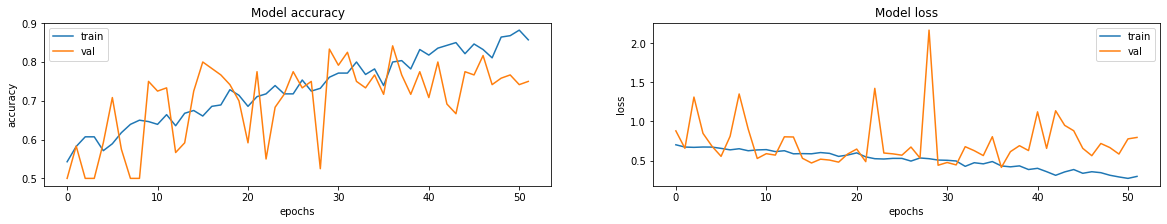

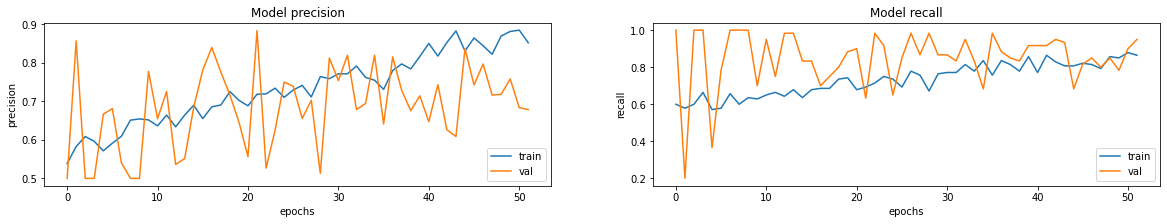

In [ ]:
# Plot model accuracy and model loss
fig_one, ax_one = plt.subplots(1, 2, figsize=(20, 3))
ax_one = ax_one.ravel()

for i, metric in enumerate(["accuracy", "loss"]):
    ax_one[i].plot(model.history.history[metric])
    ax_one[i].plot(model.history.history["val_" + metric])
    ax_one[i].set_title("Model {}".format(metric))
    ax_one[i].set_xlabel("epochs")
    ax_one[i].set_ylabel(metric)
    ax_one[i].legend(["train", "val"])
fig_two, ax_two = plt.subplots(1, 2, figsize=(20, 3))
ax_two = ax_two.ravel()

for i, metric in enumerate(["precision", "recall"]):
    ax_two[i].plot(model.history.history[metric])
    ax_two[i].plot(model.history.history["val_" + metric])
    ax_two[i].set_title("Model {}".format(metric))
    ax_two[i].set_xlabel("epochs")
    ax_two[i].set_ylabel(metric)
    ax_two[i].legend(["train", "val"])


In [ ]:
model.evaluate(test_dataset, return_dict=True)

RuntimeError: ignored

In [ ]:
def plot_confusion_matrix(dataset):
    model.load_weights("final_weights.h5")
    prediction_labels = model.predict(dataset)
    prediction_labels = np.where(prediction_labels > 0.05, 1, 0)
    dataset_labels = list(map(lambda x: x[1], dataset))
    true_labels = []
    for label in dataset_labels:
        true_labels.append(label.numpy()[0])
        true_labels.append(label.numpy()[1])
    ConfusionMatrixDisplay.from_predictions(
        true_labels, prediction_labels, display_labels=["normalne", "anormalne"]
    )
    plt.xlabel('Etykieta przewidywana')
    plt.ylabel('Etykieta prawdziwa')  
    plt.show()


50/50 [==============================] - 2s 42ms/step


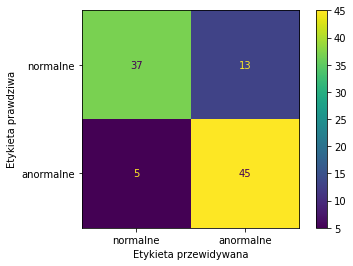

In [ ]:
plot_confusion_matrix(test_dataset)

In [ ]:
# Load best weights. Make prediction based on it.
model.load_weights("final_weights.h5")
prediction = model.predict(test_dataset)
scores = [1 - prediction[0], prediction[0]]
average = sum(prediction[48:50]) / len(prediction[48:50])
print(np.round(average, 2))

50/50 [==============================] - 2s 42ms/step
This model is 99.95 percent confident that CT scan is normal
This model is 0.05 percent confident that CT scan is abnormal
This image was normal in real
